# Graphs: Random Walk with Restart

Random walk with restart is the query biased version of PageRank: at each time point, the surfer has a constant probability to jump to the query node (Wu et al., 2016).

Tong et al. (2006) define random walk with restart as follows:

* Consider a random particle that starts from node i. The particle iteratively transmits to its neighborhood with the probability that is proportional to their edge weights. 
* Also at each step, it has some probability c to return to the node i. 
* The relevance score of node j wrt node i is defined as the steady-state probability ri,j that the particle will finally stay at node j.
* Equation:

$$\vec{r}[t+1] = (1-c)B^T\vec{r}[t] + c\vec{q}$$





In [0]:
import operator
import networkx as nx
import numpy as np
import scipy
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True, formatter={'float': '{: 0.4f}'.format}) # Suppress Scientific Notation in Numpy
# print('NetworkX version:', nx.__version__)

**Toy Graph 1**

source: Jin et al., 2017

In [0]:
# G = nx.DiGraph() # directed

# G.add_edge('A', 'B')
# G.add_edge('A', 'F')
# G.add_edge('B', 'C')
# G.add_edge('C', 'D')
# G.add_edge('C', 'E')
# G.add_edge('E', 'D')
# G.add_edge('E', 'H')
# G.add_edge('H', 'I')
# G.add_edge('I', 'G')
# G.add_edge('G', 'H')
# G.add_edge('F', 'G')
# G.add_edge('D', 'B')

# fixed_positions = {'A':(0,4), 'B':(1,6), 'C':(3,7), 'D':(3,5), 'E':(5,6), 
#                    'F':(1.5,2), 'G':(3,2), 'H':(5,3), 'I':(5,1)}


# fixed_nodes = fixed_positions.keys()
# pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)

# # show G
# nx.draw_networkx_nodes(G,pos)
# nx.draw(G, pos, with_labels=True, node_color='white')

**Toy Graph 2**

source: Wang et al., 2013

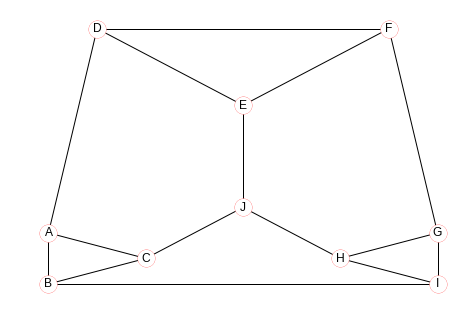

In [208]:
G = nx.Graph() # directed

G.add_edge('A', 'B')
G.add_edge('A', 'C')
G.add_edge('A', 'D')
G.add_edge('B', 'C')
G.add_edge('B', 'I')
G.add_edge('C', 'J')
G.add_edge('H', 'G')
G.add_edge('H', 'I')
G.add_edge('H', 'J')
G.add_edge('G', 'F')
G.add_edge('E', 'F')
G.add_edge('D', 'F')
G.add_edge('D', 'E')
G.add_edge('E', 'J')
G.add_edge('G', 'I')

fixed_positions = {'A':(1,2), 'B':(1,1), 'C':(2,1.5), 'D':(1.5,6), 'E':(3,4.5), 
                   'F':(4.5,6), 'G':(5,2), 'H':(4,1.5), 'I':(5,1), 'J':(3,2.5)}


fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)

# show G
nx.draw_networkx_nodes(G,pos)
nx.draw(G, pos, with_labels=True, node_color='white')

*Step 1: Compute adjaceny matrix $H$ from $G$.*

In [0]:
# Get the Adjacency matrix H
# H = nx.to_scipy_sparse_matrix(G, nodelist=['A','B','C','D','E','F','G','H','I']) # example 1
H = nx.to_scipy_sparse_matrix(G, nodelist=['A','B','C','D','E','F','G','H','I', 'J']) # example 2
H = H.todense()
# print('\nAdjacency Matrix H of G:\n', H)

*Step 2: Compute row-normailized transition matrix $B$ from $H$.*

In [0]:
L, D = scipy.sparse.csgraph.laplacian(csgraph=H, return_diag=True, use_out_degree=True) # important to specify the use of out degree!! 
degree_matrix = np.diag(D) # np.diag is needed to turn the degree array returned by scipy into a matrix
D_inv = np.linalg.inv(degree_matrix)
B = D_inv * H # row-normalized adjacency (transition) matrix
# print('\nRow-normalized Adjacency (Transition) Matrix:\n\n', B)  

*Step 3: Compute the RWR score vector $\vec{r}$ w.r.t. some node*



In [211]:
# Initialize useful parameters
N = nx.number_of_nodes(G)
# c=0.5
c=0.1
error = 0.0001

# q = np.array([1,0,0,0,0,0,0,0,0]) # starting vector example 1 (Node A)
q = np.array([0,0,0,0,0,0,0,0,0,1]) # starting vector example 2 (Node J)
q.shape = (N,1) # force it to be a column vector

# Iterate
flag = 1 # stop flag
i = 0 # iterations counter
r = q # initialize RWR scores vector 
while flag:
  i += 1
  r_new = ((1-c) * B.T * r) + (c * q)
  if(np.all(abs(np.subtract(r_new, r)) < error)): # test for convergence
#   if(np.linalg.norm(r_new) == np.linalg.norm(r)): # test for convergence (option 2)
    flag = 0
  r = r_new # update RWR score vector

print('\nFinal RWR score vector:', r.T) # out of curiosity

# get index of highest ranked node
index, value = max(enumerate(r.tolist()), key=operator.itemgetter(1))
pos = index+1
print('Node %i has highest score.\n' %pos) # list is indexed at zero
print('Number of iterations required to reach desired convergence:', i)


Final RWR score vector: [[ 0.0804  0.0804  0.1072  0.0804  0.1072  0.0804  0.0804  0.1072  0.0804
   0.1964]]
Node 10 has highest score.

Number of iterations required to reach desired convergence: 19


**References**

Wu, Y., Bian, Y. and Zhang, X. 2016. Remember Where You Came from: On the Second-order Random Walk Based Proximity Measures. Proc. VLDB Endow., 10(1), pp.13–24. [link](http://www.vldb.org/pvldb/vol10/p13-wu.pdf)

Tong, H., Faloutsos, C. and Pan, J.-Y. 2006. Fast random walk with restart and its applications.

Jin, W., Jung, J. and Kang, U. 2017. Supervised and Extended Restart in Random Walks for Ranking and Link Prediction in Networks. arXiv:1710.06609.

Wang, H., Chang, C.K., Yang, H.-I. and Chen, Y. 2013. Estimating the Relative Importance of Nodes in Social Networks. Journal of Information Processing, 21(3), pp.414–422. [link](https://www.jstage.jst.go.jp/article/ipsjjip/21/3/21_414/_pdf)


**Useful LInks**

[A Comparative Study of Matrix Factorization and Random Walk with Restart in Recommender Systems](https://arxiv.org/pdf/1708.09088.pdf)

[Reverse Top-k Search using Random Walk with Restart](http://www.cs.hku.hk/research/techreps/document/TR-2013-08.pdf)

[Document Retrieval Method Using Random Walk with Restart on Weighted Co-citation Network](https://onlinelibrary.wiley.com/doi/pdf/10.1002/meet.2014.14505101126)

[A network-based method using a random walk with restart algorithm and screening tests to identify novel genes associated with Menière's disease](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182592)

**Notes**

* Jin et al. has a good section on limitations of RWR